In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns

In [2]:
#Data reading

train = pd.read_csv(r"C:\Users\user\Desktop\Kaggle\HousePrices\Data\train.csv")
test = pd.read_csv(r"C:\Users\user\Desktop\Kaggle\HousePrices\Data\test.csv")

In [3]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# 1. Data Cleaning and Pre-processing
## Outliers
According to the documentation of the dataset (http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) there are outliers present that are recommended to be removed. Let's plot SalePrice vs GR LIV AREA to view these. 

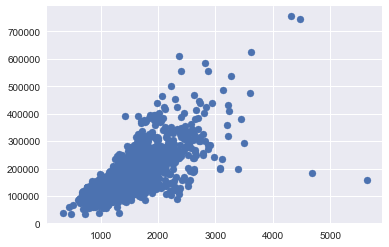

In [4]:
plt.scatter(train.GrLivArea, train.SalePrice)

These outliers are extremely clear. The documentation recommends removing all houses above 4000 sq ft living area. Trial and error showed that this led to a little bit underfitting. Better performance was above 4500 sq.

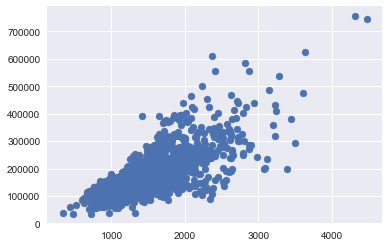

In [5]:
train = train[train.GrLivArea < 4500]
plt.scatter(train.GrLivArea, train.SalePrice)

In [6]:
print(len(np.unique(train['Id'])) == len(train))
len(np.unique(test['Id'])) == len(test)

True


True

In [7]:
len(train)

1458

So we can safely drop the Id columns.

In [8]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [9]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1458, 80)
Test set size: (1459, 79)


## Statistical transformation
Let's have a look at how the target variable is distributed.

In [10]:
df = pd.concat([train.SalePrice, np.log(train.SalePrice + 1).rename('LogSalePrice')], axis=1, names=['SalePrice', 'LogSalePrice'])
df.head()

,SalePrice,LogSalePrice
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


Text(0.5,0,'Log SalePrice')

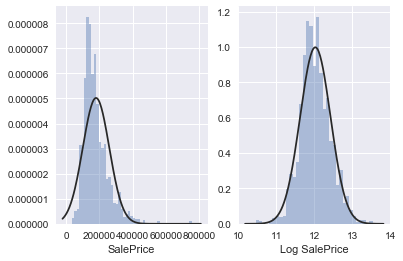

In [11]:
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

There seems to be clear evidence of right-skewedness in the target variable. We can correct this with a simple log transformation.

In [12]:
train.SalePrice = np.log1p(train.SalePrice)

# 2. Feature Engineering
## Concatenation
To keep consistency between test and train features we concatenate the two sets while remembering the index so we can split it later again.

In [13]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [14]:
print(train_features.shape)
print(test_features.shape)

(1458, 79)
(1459, 79)


In [15]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2917, 79)

## NA's
Let's figure out what NA's excist, sort them by categories and impute them in the best possible way.

In [16]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

Most of these can be filled with 'None'. Some exceptions though:

- Functional: The documentation says that we should assume "Typ", so lets impute that.
- Electrical: The documentation doesn't give any information but obviously every house has this so let's impute the most common value: "SBrkr".
- KitchenQual: Similar to Electrical, most common value: "TA".
- Exterior 1 and Exterior 2: Let's use the most common one here. 
- SaleType: Similar to electrical, let's use most common value.


In [17]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

Let's check some points individually to figure out the best imputation strategy

In [18]:
pd.set_option('max_columns', None)
features[features['PoolArea'] > 0 & features['PoolQC'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
809,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1169,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1181,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1384,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,TA,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1421,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1972,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,Ex,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2418,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2571,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8

There are three NaN's foor PoolQC that have a PoolArea. Let's impute them based on overall quality of the house.

In [19]:
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'

In [20]:
pd.set_option('max_columns', None)
features[(features['GarageType'] == 'Detchd') & features['GarageYrBlt'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


So there are houses with garages that are detached but that have NaN's for all other Garage variables. Let's impute these manually too.

In [21]:
features.loc[2124, 'GarageYrBlt'] = features['GarageYrBlt'].median()
features.loc[2574, 'GarageYrBlt'] = features['GarageYrBlt'].median()

features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]

features.loc[2574, 'GarageCars'] = features['GarageCars'].median()

features.loc[2124, 'GarageArea'] = features['GarageArea'].median()
features.loc[2574, 'GarageArea'] = features['GarageArea'].median()

features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]

features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]

Let's look at the basements:
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtFinSF1
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF

In [22]:
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF']

tempdf = features[basement_columns]
tempdfnulls = tempdf[tempdf.isnull().any(axis=1)]

In [23]:
#now select just the rows that have less then 5 NA's, 
# meaning there is incongruency in the row.
tempdfnulls[(tempdfnulls.isnull()).sum(axis=1) < 5]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0
947,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0
1485,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
2038,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
2183,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
2215,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
2216,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
2346,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0
2522,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0


Let's impute all incongruencies with the most likely value.

In [24]:
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

Zoning is also interesting

In [25]:
subclass_group = features.groupby('MSSubClass')
Zoning_modes = subclass_group['MSZoning'].apply(lambda x : x.mode()[0])
Zoning_modes

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [26]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

For the rest we will just use a loop to impute 'None' value. 

In [27]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
LotFrontage   486  float64
GarageYrBlt   157  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
There are 9 columns with missing values


Now let's think about imputing the missing values in the numerical features. Most of the time I will impute 0, but sometimes something else is needed.

- LotFrontage: This is linear feet of street connected to property. Let's impute with the median per neighborhood since I assume this is extremely linked to what kind of area you live in.

In [28]:
neighborhood_group = features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
lot_medians

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

As expected the lotfrontage averages differ a lot per neighborhood so let's impute with the median per neighborhood.

In [29]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Let's also take a closer look at GarageYrBlt

In [30]:
pd.set_option('max_columns', None)
features[(features['GarageYrBlt'].isnull()) & features['GarageArea'] > 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


GarageYrBlt does not have any incongruencies. Let's also examine MasVnrArea.

In [31]:
pd.set_option('max_columns', None)
features[(features['MasVnrArea'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
234,60,RL,64.0,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625.0,Unf,0.0,235.0,860.0,GasA,Ex,Y,SBrkr,860,1100,0,1960,1.0,0.0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2.0,440.0,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal
528,20,RL,70.0,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219.0,Unf,0.0,816.0,2035.0,GasA,TA,Y,SBrkr,2515,0,0,2515,1.0,0.0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2.0,484.0,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca
649,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,813.0,813.0,GasA,Ex,Y,SBrkr,822,843,0,1665,0.0,0.0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2.0,562.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
935,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833.0,Unf,0.0,343.0,1176.0,GasA,Ex,Y,SBrkr,1200,0,0,1200,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2.0,555.0,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal
972,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1428.0,1428.0,GasA,Ex,Y,SBrkr,1428,0,0,1428,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2.0,480.0,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial
976,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106.0,Unf,0.0,135.0,1241.0,GasA,Ex,Y,SBrkr,1241,0,0,1241,1.0,0.0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2.0,569.0,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial
1242,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial
1277,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804.0,Unf,0.0,324.0,1128.0,GasA,Ex,Y,SBrkr,1128,903,0,2031,1.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal
1689,60,RL,64.0,12891,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.0,Fin,3.0,644.0,TA,TA,Y,0,48,0,0,0,0,None,None,None,0,7,2009,WD,Normal
1704,20,FV,90.0,7993,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,Com

No incongruencies here either.
The rest can be safely imputed with 0 since this means that the property is not present in the house.

In [32]:
#Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
features.update(features[numerics].fillna(0))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


## Incorrect values
Some values can be obviously wrong and this might impact our model. I used min and max values to check odd values in the data.

In [33]:
features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,69.436064,10139.439150,6.086390,5.564964,1971.287967,1984.248200,100.931436,438.864930,49.599246,560.50360,1048.967775,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1871.627014,1.766198,472.453205,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,21.208242,7807.036512,1.406704,1.113414,30.286991,20.892257,178.032499,444.180542,169.232130,439.69883,429.472008,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,447.158503,0.761412,214.574064,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.00000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.00000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.00000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,733.000000,0.000000,804.00000,1302.000000,1384.000000,704.000000,0.000000,1743.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.00000,5095.000000,5095.000000,2065.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Looking at the min and max of each variable there are some errors in the data.

- GarageYrBlt - the max value is 2207, this is obviously wrong since the data is only until 2010. 

The rest of the data looks fine. Let's inspect this row a bit more carefully and impute an approximate correct value.

In [34]:
features[features['GarageYrBlt'] == 2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2590,20,RL,68.0,8298,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,None,None,None,0,9,2007,New,Partial


This particular datapoint has YearBuilt in 2006 and YearRemodAdd in 2007. 2207 most likely is a data input error that should have been 2007 when the remodel happened. Let's impute 2007.

In [35]:
features.loc[2590, 'GarageYrBlt'] = 2007

## Factorization
There are features that are read in as numericals but are actually objects. Let's transform them.

In [36]:
#factors = ['MSSubClass', 'MoSold']
factors = ['MSSubClass']
 


for i in factors:
    features.update(features[i].astype('str'))

## Skew transformation features
Let's check skew in our features and transform if necessary.

In [37]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


I use the boxcox1p transformation here because I tried the log transform first but a lot of skew remained in the data. I use boxcox1p over normal boxcox because boxcox can't handle zero values.

In [38]:
high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index
#skew_to_drop = ['KitchenAbvGr', 'BsmtHalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'BsmtFullBath','OverallCond']
#skew_index = skew_index.drop(skew_to_drop)

print(skew_index)

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'TotalBsmtSF', 'BsmtFullBath',
       'OverallCond'],
      dtype='object')


In [39]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


## Incomplete cases
Checking to see if levels of my variables in my train and test set match and if not or if the level distribution is very low whether it should be deleted.

In [40]:
objects3 = []
for i in features.columns:
    if features[i].dtype == object:
        objects3.append(i)

In [41]:
print("Training Set incomplete cases")

sums_features = features[objects3].apply(lambda x: len(np.unique(x)))
sums_features.sort_values(ascending=False)

Training Set incomplete cases


Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          7
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
BsmtQual          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
BsmtExposure      5
ExterCond         5
Electrical        5
BsmtCond          5
GarageFinish      4
LotShape          4
ExterQual         4
PoolQC            4
KitchenQual       4
MasVnrType        4
LandContour       4
Alley             3
LandSlope         3
Utilities         3
PavedDrive        3
Street            2
CentralAir        2
dtype: int64

Let's take a closer look at some of these lower numbered variables.

In [42]:
print(features['Street'].value_counts())
print('-----')
print(features['Utilities'].value_counts())
print('-----')
print(features['CentralAir'].value_counts())
print('-----')
print(features['PavedDrive'].value_counts())

Pave    2905
Grvl      12
Name: Street, dtype: int64
-----
AllPub    2914
None         2
NoSeWa       1
Name: Utilities, dtype: int64
-----
Y    2721
N     196
Name: CentralAir, dtype: int64
-----
Y    2639
N     216
P      62
Name: PavedDrive, dtype: int64


I experimented a bunch with this and decided in the end that if a column has low amount of levels and most values are in the same class (>97%) I'd remove them.

Let's delete Utilities because of how unbalanced it is.

In [43]:
#features = features.drop(['Utilities'], axis=1)
features = features.drop(['Utilities', 'Street'], axis=1)

## Creating features
In this section I create some features that can be created from the current data. 

Size of the house. There are a few variables dealing with square footage, I don't use TotalBsmtSF as a proxy for the basement because I believe unfinished square feet in the basement area won't have a big impact on price as it needs money to make it 'livable' square footage, so I just use BsmtSF1 and BsmtSF2.
- BsmtFinSF1
- BsmtFinSF2
- 1stFlrSF 
- 2ndFlrSF

Another combined variable is the bathrooms in the house. I count fullbath for 1 and halfbath for 0.5.
- FullBath
- HalfBath
- BsmtFullBath
- BsmtHalfBath

Another combined variable is the total porch size.
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- Screenporch
- WoodDeckSF

Next to that I make some simplified features.
- haspool
- has2ndfloor
- hasgarage
- hasbsmt
- hasfireplace

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [44]:
features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_sqr_feet'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                features['1stFlrSF'] + features['2ndFlrSF'])

In [45]:
features.drop(['FullBath', 'HalfBath', '1stFlrSF', '2ndFlrSF', 'GarageArea'], axis = 1) # , 'BsmtFinSF1', 'BsmtFinSF2'

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_Bathrooms,Total_sqr_feet
0,60,RL,18.144572,13.833055,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.433174,Gd,TA,PConc,Gd,TA,No,GLQ,144.117862,Unf,0.000000,29.991052,422.488452,GasA,Ex,Y,SBrkr,0.0,8.353544,0.993440,0.000000,3,0.750957,Gd,2.261968,Typ,0.000000,None,Attchd,2003.0,RFn,2.0,TA,TA,Y,0.000000,12.080309,0.000000,0.000000,0.000000,0.0,None,None,None,0.000000,2,2008,WD,Normal,3.527858,1175.708874
1,20,RL,20.673625,14.117918,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,6.000033,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.719186,Unf,0.000000,44.135410,593.888092,GasA,Ex,Y,SBrkr,0.0,7.974694,0.000000,0.710895,3,0.750957,TA,1.996577,Typ,0.903334,TA,Attchd,1976.0,RFn,2.0,TA,TA,Y,56.184225,0.000000,0.000000,0.000000,0.000000,0.0,None,None,None,0.000000,5,2007,WD,Normal,2.355448,187.954175
2,60,RL,18.668046,14.476513,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.768840,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.441033,Unf,0.000000,56.896528,450.079654,GasA,Ex,Y,SBrkr,0.0,8.408065,0.993440,0.000000,3,0.750957,Gd,1.996577,Typ,0.903334,TA,Attchd,2001.0,RFn,2.0,TA,TA,Y,0.000000,9.901081,0.000000,0.000000,0.000000,0.0,None,None,None,0.000000,9,2008,WD,Normal,3.527858,1156.956428
3,70,RL,17.249650,14.106197,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.991517,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.795315,Unf,0.000000,64.808848,378.854517,GasA,Gd,Y,SBrkr,0.0,8.358663,0.993440,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Detchd,1998.0,Unf,3.0,TA,TA,Y,0.000000,8.966116,16.020712,0.000000,0.000000,0.0,None,None,None,0.000000,2,2006,WD,Abnorml,1.993440,972.300439
4,60,RL,21.314282,15.022009,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.991517,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.404163,Gd,TA,PConc,Gd,TA,Av,GLQ,136.624601,Unf,0.000000,61.166371,545.309849,GasA,Ex,Y,SBrkr,0.0,8.669322,0.993440,0.000000,4,0.750957,Gd,2.373753,Typ,0.903334,TA,Attchd,2000.0,RFn,3.0,TA,TA,Y,42.245703,14.271569,0.000000,0.000000,0.000000,0.0,None,None,None,0.000000,12,2008,WD,Normal,3.527858,1415.810684
5,50,RL,21.472480,14.998258,None,IR1,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,3.991517,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,147.876483,Unf,0.000000,17.718036,396.388924,GasA,Ex,Y,SBrkr,0.0,8.069454,0.993440,0.000000,1,0.750957,TA,1.834659,Typ,0.000000,None,Attchd,1993.0,Unf,2.0,TA,TA,Y,14.912200,8.235430,0.000000,7.114653,0.000000,0.0,None,MnPrv,Shed,6.937473,10,2009,WD,Normal,2.527858,824.789316
6,20,RL,19.854050,14.228590,None,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,3.991517,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,18.962283,Gd,TA,PConc,Ex,TA,Av,GLQ,230.755721,Unf,0.000000,47.147306,765.641232,GasA,Ex,Y,SBrkr,0.0,8.341767,0.993440,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Attchd,2004.0,RFn,2.0,TA,TA,Y,50.794698,11.655819,0.000000,0.000000,0.000000,0.0,None,None,None,0.000000,8,2007,WD,Normal,2.993440,237.212265
7,60,RL,20.673625,14.294345,None,IR1,Lvl,Corner,Gtl,NWAmes,Po

## Creating Dummies
Since sklearn lm.fit() does not accept strings we have to convert our objects to dummy variables. 

In [46]:
features.shape

(2917, 79)

In [47]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 315)

Now we resplit the model in test and train

In [48]:
y.shape

(1458,)

In [49]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)

(1458, 315)
(1459, 315)


## Overfitting prevention

### Outliers
Let's do a little bit more in-depth and rigorous analysis first on outliers. I'll employ Leave-One-Out methodology with OLS to find which points have a significant effect on our model fit.  

In [ ]:
import statsmodels.api as sm

ols = sm.OLS(endog = y, exog = X)

fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']

In [ ]:
outliers = list(test2[test2<1e-3].index) 

outliers

#print(test[test<1e-3])

In [50]:
outliers = [30, 88, 462, 631, 1322]

So we find that these are outliers. Let's delete these.

In [51]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

### Dummy levels

To prevent overfitting I'll also remove columns that have more than 97% 1 or 0 after doing pd.get_dummies.

In [52]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.94:
        overfit.append(i)

In [53]:
overfit = list(overfit)
overfit

['MSSubClass_150', 'BsmtQual_Po']

Let's drop these from 'X' and 'testing_features'. Let's also drop MSZoning_C (all). It has about 99.44% zeros but unlike others with that kind of percentage it's being included in my lasso/ridge/elasticnet models with quite strong coefficient sizes.

In [54]:
overfit.append('MSZoning_C (all)')

In [55]:
overfit

['MSSubClass_150', 'BsmtQual_Po', 'MSZoning_C (all)']

In [56]:
X.drop(overfit,axis=1,inplace=True)
testing_features.drop(overfit,axis=1,inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
print(X.shape)
print(testing_features.shape)

(1453, 312)
(1459, 312)


### Lasso Quick CV

In [61]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf, verbose = 2))
    return(rmse)

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=4321))
#lasso = Lasso(alpha =0.0005, random_state=4321)
%time lasso.fit(X, y)

#LASSO CV
score = rmsle_cv(lasso)
print("\nLASSO score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wall time: 273 ms
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s

LASSO score: 0.1034 (0.0057)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


### lightgbm

In [59]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720, max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, n_jobs = 1)

%time model_lgb.fit(X, y)

#model_lgb CV
score = rmsle_cv(model_lgb)
print("\nmodel_lgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wall time: 493 ms
[CV]  ................................................................
[CV] ................................................. , total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s

model_lgb score: 0.1074 (0.0055)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


### XGBoost

In [60]:
import xgboost as xgb

xgbr =make_pipeline(RobustScaler(), xgb.XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,colsample_bytree=0.7,objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, reg_alpha=0.00006))



%time xgbr.fit(X, y)


score = rmsle_cv(xgbr)
print("\nxgbscore: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wall time: 26.6 s
[CV]  ................................................................
[CV] ................................................. , total=  22.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.4s remaining:    0.0s


[CV] ................................................. , total=  25.3s
[CV]  ................................................................
[CV] ................................................. , total=  24.6s
[CV]  ................................................................
[CV] ................................................. , total=  25.3s
[CV]  ................................................................
[CV] ................................................. , total=  25.7s

xgbscore: 0.1079 (0.0049)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


## Feather

In [61]:
import feather

feather.write_dataframe(X, 'X_train_FE_D_11.feather')
feather.write_dataframe(testing_features, 'test_FE_D_11.feather')
y.to_csv('y_train_FE_D_11.csv',index=False)